## Youtube

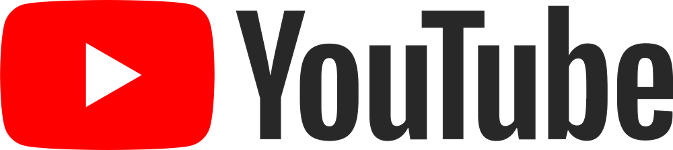

### Getting Developer Key

* follow this [video tutorial](https://www.youtube.com/watch?v=pP4zvduVAqo)
* or text instructions at https://developers.google.com/youtube/v3/getting-started

### Getting Started

* Youtube provides 1 million credits free per day
* Usual operations cost between 1 and 10 credits, leading to ca. 100k api calls per day
* [API Documentation](https://developers.google.com/youtube/v3/docs/videos/list)

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

DEVELOPER_KEY = os.environ['YOUTUBE_KEY']

### Utility Functions

We need some utility functions to wrap the Youtube API.
The API has lots of error cases, timeouts, recoverable errors, etc. that we need to take care of.

In [2]:
import logging
from apiclient.discovery import build
from googleapiclient.errors import HttpError

logging.getLogger('googleapicliet.discovery_cache').setLevel(logging.ERROR)

YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

youtube = build(YOUTUBE_API_SERVICE_NAME,
                YOUTUBE_API_VERSION,
                developerKey=DEVELOPER_KEY,
                cache_discovery=False)

def runner(func, max_results=50, perPage=50, iterate=True, **kwargs):
    """ utility function for pagination, etc. """
    results_rem = max_results

    nexttok = None
    while results_rem > 0:
        kwargs = dict(kwargs,
                      pageToken=nexttok,
                      maxResults=perPage)

        try:
            search_response = func(**kwargs).execute()
        except HttpError as e:
            logging.warning('content: %r', e.content)
            break

        for search_result in search_response.get('items', []):
            yield search_result

        nexttok = search_response.get('nextPageToken')
        if nexttok is None or not iterate:
            break
        results_rem -= perPage


def search_videos(q, max_results=200, order='relevance'):
    """
    search youtube videos
    order: date, rating, relevance, title, videoCount, viewCount
    """
    return runner(
        youtube.search().list,
        max_results=max_results,
        q=q,
        type='video',
        order=order,
        part='id,snippet',
    )

def get_videos(video_ids):
    """ get details for comma-separated video_ids """
    return runner(
        youtube.videos().list,
        part='id,snippet,topicDetails',
        id=video_ids)

### 200 Machine Learning videos

Let's find the 200 most recent videos about "machine learning".

In [3]:
import json

res = list(search_videos('machine learning', max_results=200, order='date'))

video_id = res[198]['id']['videoId']
detailed = list(get_videos(video_id))
print(json.dumps(detailed, indent=4))

[
    {
        "kind": "youtube#video",
        "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/VrDqG-Iu2PHDrzquqWy4mZwkvco\"",
        "id": "y9U10qdDQqk",
        "snippet": {
            "publishedAt": "2018-04-03T15:02:37.000Z",
            "channelId": "UCqoAEDirJPjEUFcF2FklnBA",
            "title": "MKBHD & Neil Tyson \u2014 Artificial Intelligence vs. Machine Learning",
            "description": "This week Neil deGrasse Tyson and Chuck Nice discuss the differences between AI and machine learning with special guest, MKBHD himself, Marques Brownlee. Keep ahead of the robots at https://brilliant.org/StarTalk where you'll find courses that enrich your problem-solving skills.\n\n**********************************\nAlso, check out this MKBHD video where Neil, Chuck, and Marques talk some serious tech: https://www.youtube.com/watch?v=pqQrL1K0Z5g\n\nGet 20% off Brilliant: https://brilliant.org/StarTalk/\n***********************************\nFor more exclusive content and commercial-free full 

### Video Comments

Let's fetch comments for the above video, even though it is a very recent upload.

In [4]:
def video_comments(videoId, q=None, max_results=50):
    """ fetch comments for video `videoId` """
    return runner(
        youtube.commentThreads().list,
        max_results=max_results,
        part='id,replies,snippet',
        order='relevance',
        videoId=videoId,
        searchTerms=q,
        textFormat='plainText'
    )

comments = list(video_comments(video_id))
print(json.dumps(comments, indent=4))

[
    {
        "kind": "youtube#commentThread",
        "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/G5Udb6XNDzSZ33SwB2jOUEzbuq4\"",
        "id": "UgwyrcfCdRYrK4y1nOF4AaABAg",
        "snippet": {
            "videoId": "y9U10qdDQqk",
            "topLevelComment": {
                "kind": "youtube#comment",
                "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/EAvwQTGL0u2WUyshGIAjDnc_cE8\"",
                "id": "UgwyrcfCdRYrK4y1nOF4AaABAg",
                "snippet": {
                    "authorDisplayName": "Marques Brownlee",
                    "authorProfileImageUrl": "https://yt3.ggpht.com/-lNGwllze1Xk/AAAAAAAAAAI/AAAAAAAAAAA/N6QnsHGN7Fk/s28-c-k-no-mo-rj-c0xffffff/photo.jpg",
                    "authorChannelUrl": "http://www.youtube.com/channel/UCBJycsmduvYEL83R_U4JriQ",
                    "authorChannelId": {
                        "value": "UCBJycsmduvYEL83R_U4JriQ"
                    },
                    "videoId": "y9U10qdDQqk",
                    "textDisplay": "\ud

## Other Capabilities

* find related videos
* fetch channel information and videos
* fetch closed captions
* given oauth permissions also possible to fetch user history, likes, subscriptions, etc.